# 统计 KITTI-360 以及 STF 中点云 Z 轴的分布

Loaded dataset: Dataset({
    features: ['sample_id', 'xyz', 'reflectance', 'depth', 'mask'],
    num_rows: 50348
})
First pass: computing global z min/max...


first pass:  20%|█▉        | 10000/50348 [00:57<03:50, 175.04it/s]


First pass done. Processed 10000 images, skipped 0.
Global z range: [-32.0543, 2.9125]
Second pass: accumulating histograms...


second pass:  20%|█▉        | 10000/50348 [00:31<02:06, 319.96it/s]



Second pass done. Processed 10000 images, skipped 0.


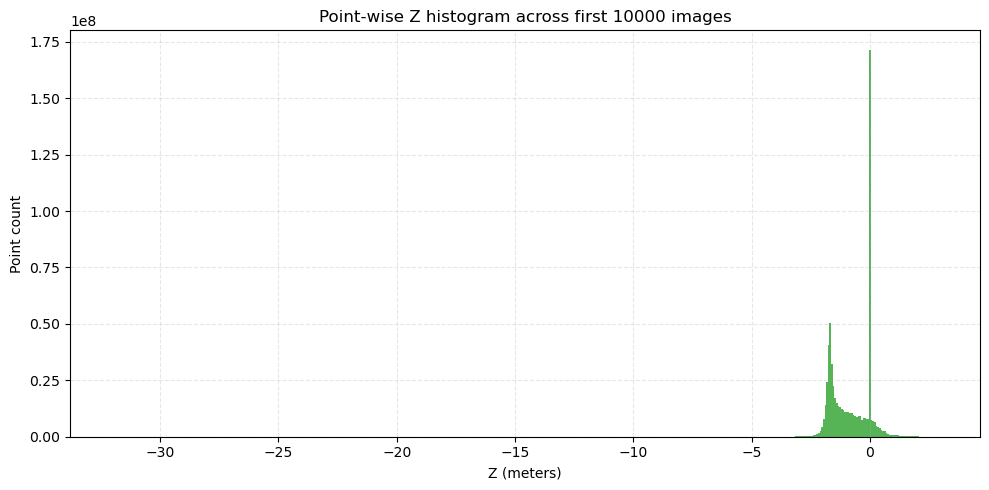

Saved z_pointwise_histogram.png, z_hist_counts.npy, z_hist_edges.npy


In [2]:
# 对前 N_images 张图像的所有点逐点统计 Z 值，累加成全局直方图（逐图累加以节省内存）
import datasets as ds
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm.auto import tqdm

# 参数
dataset_path = 'data/kitti_360'
projection = 'spherical-1024'
split = ds.Split.TRAIN
N_images = 10000  # 要统计的图像数量上限
n_bins = 500  # 直方图 bin 数量，可调整

# 加载数据集
dataset = ds.load_dataset(path=dataset_path, name=projection, split=split, trust_remote_code=True).with_format('torch')
print(f'Loaded dataset: {dataset}')

# 两遍扫描策略：第一遍确定 z 范围（min,max），第二遍累加直方图
global_min = float('inf')
global_max = float('-inf')
processed = 0
skipped = 0

print('First pass: computing global z min/max...')
for i, sample in enumerate(tqdm(dataset, desc='first pass')):
    if processed >= N_images:
        break
    if 'xyz' not in sample:
        skipped += 1
        continue
    xyz = sample['xyz']
    if isinstance(xyz, torch.Tensor):
        xyz = xyz.cpu().numpy()
    try:
        if xyz.ndim == 3:
            C, H, W = xyz.shape
            pts = xyz.reshape(C, -1).T
        elif xyz.ndim == 2 and xyz.shape[0] == 3:
            pts = xyz.T
        else:
            pts = xyz.reshape(-1, 3)
    except Exception:
        skipped += 1
        continue

    z_vals = pts[:, 2]
    mask = np.isfinite(z_vals) & (np.abs(z_vals) < 1e6)
    z_vals = z_vals[mask]
    if z_vals.size == 0:
        skipped += 1
        continue

    global_min = min(global_min, float(z_vals.min()))
    global_max = max(global_max, float(z_vals.max()))
    processed += 1

if processed == 0:
    raise RuntimeError('No valid images found in first pass. Check dataset path/projection or dataset contents.')

print(f'First pass done. Processed {processed} images, skipped {skipped}.')
print(f'Global z range: [{global_min:.4f}, {global_max:.4f}]')

# 初始化直方图计数
hist_counts = np.zeros(n_bins, dtype=np.int64)
bin_edges = np.linspace(global_min, global_max, n_bins + 1)

# 第二遍：累加每张图的直方图
processed2 = 0
skipped2 = 0
print('Second pass: accumulating histograms...')
for i, sample in enumerate(tqdm(dataset, desc='second pass')):
    if processed2 >= N_images:
        break
    if 'xyz' not in sample:
        skipped2 += 1
        continue
    xyz = sample['xyz']
    if isinstance(xyz, torch.Tensor):
        xyz = xyz.cpu().numpy()
    try:
        if xyz.ndim == 3:
            C, H, W = xyz.shape
            pts = xyz.reshape(C, -1).T
        elif xyz.ndim == 2 and xyz.shape[0] == 3:
            pts = xyz.T
        else:
            pts = xyz.reshape(-1, 3)
    except Exception:
        skipped2 += 1
        continue

    z_vals = pts[:, 2]
    mask = np.isfinite(z_vals) & (np.abs(z_vals) < 1e6)
    z_vals = z_vals[mask]
    if z_vals.size == 0:
        skipped2 += 1
        continue

    counts, _ = np.histogram(z_vals, bins=bin_edges)
    hist_counts += counts
    processed2 += 1

if processed2 == 0:
    raise RuntimeError('No valid images processed in second pass.')

print(f'Second pass done. Processed {processed2} images, skipped {skipped2}.')

# 绘制累积直方图
plt.figure(figsize=(10, 5))
centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
plt.bar(centers, hist_counts, width=(bin_edges[1]-bin_edges[0]), color='C2', alpha=0.8)
plt.title(f'Point-wise Z histogram across first {processed2} images')
plt.xlabel('Z (meters)')
plt.ylabel('Point count')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig('z_pointwise_histogram.png', dpi=150)
plt.show()

# 保存直方图数据
np.save('z_hist_counts.npy', hist_counts)
np.save('z_hist_edges.npy', bin_edges)
print('Saved z_pointwise_histogram.png, z_hist_counts.npy, z_hist_edges.npy')